In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/galaxydecals10-compressed-dataset/Tensor_X_valid.pt
/kaggle/input/galaxydecals10-compressed-dataset/numpy_y_valid.npy
/kaggle/input/galaxydecals10-compressed-dataset/Tensor_X_test.pt
/kaggle/input/galaxydecals10-compressed-dataset/numpy_y_train.npy
/kaggle/input/galaxydecals10-compressed-dataset/numpy_y_test.npy
/kaggle/input/galaxydecals10-compressed-dataset/Tensor_X_train.pt
/kaggle/input/galaxydecal10compressionalert/Tensor_X_valid.pt
/kaggle/input/galaxydecal10compressionalert/numpy_y_valid.npy
/kaggle/input/galaxydecal10compressionalert/Tensor_X_test.pt
/kaggle/input/galaxydecal10compressionalert/numpy_y_train.npy
/kaggle/input/galaxydecal10compressionalert/numpy_y_test.npy
/kaggle/input/galaxydecal10compressionalert/Tensor_X_train.pt


In [4]:
!pip install AstroNN
!pip install albumentations
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 6.9 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 86.6 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.9/888.9 kB 54.7 MB/s eta 0:00:00


In [5]:
# Load the import modules
from astroNN.datasets import load_galaxy10
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from tensorflow.keras import utils
import tensorflow as tf
from tqdm import tqdm
import random
import torch
from sklearn.manifold import TSNE
from skimage.transform import resize
from sklearn.preprocessing import OneHotEncoder
import albumentations as A
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [6]:
#Load Galaxy 10 Dataset
images, labels = load_galaxy10()

Galaxy10_DECals.h5: 100%|█████████▉| 2.73G/2.74G [00:54<00:00, 52.0MB/s]    

Downloaded Galaxy10 successfully to /root/.astroNN/datasets/Galaxy10_DECals.h5


Galaxy10_DECals.h5: 2.74GB [01:01, 44.5MB/s]                            


In [7]:
def plot_random_galaxy(images, sample = 9):
    random_image_indexes=random.sample(list(range(images.shape[0])),sample)
    print(random_image_indexes)
    if (np.sqrt(sample) - int(np.sqrt(sample))) == 0:
        sqrt = int(np.sqrt(sample))
        Length, width = sqrt, sqrt
    else:
        Length, width = 1, sample
    
    fig = plt.figure(figsize=(20,20))
    for index, values in enumerate(random_image_indexes):
        plt.subplot(Length,width,index+1)
        plt.imshow(images[values])
        plt.title(f'Galaxy_id: {random_image_indexes[index]}\nShape: {images.shape}')
    return fig

100%|██████████| 17736/17736 [00:12<00:00, 1452.72it/s]


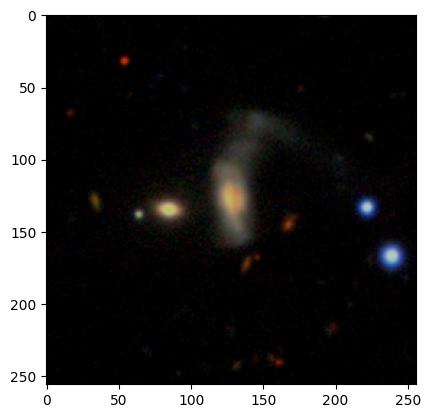

In [8]:
transform = A.Compose([
    A.Rotate(30, p = 0.3),
    A.RandomBrightnessContrast(p = 0.3),
    A.HorizontalFlip(p = 0.5),
    A.Rotate(45, p = 0.4),
])
transformed_images = []
preprocessing_func = lambda x: transform(image = x)
for image_index in tqdm(range(len(images))):
    transformed_images.append(transform(image = images[image_index])["image"])
plt.imshow(transformed_images[0])

In [9]:
transformed_images = np.array(transformed_images)
transformed_images.shape

(17736, 256, 256, 3)

In [10]:
Adjusted_Images = np.concatenate([images, transformed_images])
Adjusted_Images.shape

(35472, 256, 256, 3)

In [11]:
Adjusted_Images = images

In [12]:
def plot_random_galaxy(images, sample = 9):
    random_image_indexes = random.sample(list(Adjusted_Images[:,0,0,0]), sample)
    if (np.sqrt(sample) - int(np.sqrt(sample))) == 0:
        sqrt = int(np.sqrt(sample))
        Length, width = sqrt,sqrt
    else:
        Length, width = 1, sample
    
    fig = plt.figure(figsize = (20,20))
    for index, values in enumerate(random_image_indexes):
        plt.subplot(Length, width, index+1)
        plt.imshow(images[values])
        plt.title(f"Galaxy_id: {random_image_indexes[index]}\n Shape: {images.shape}")
    return fig
fig = plot_random_galaxy(Adjusted_Images)
plt.show()

In [13]:
ORIG_SHAPE = (256, 256)
CROP_SIZE = (150, 150)
IMG_SHAPE = (64,64)

def get_image(image, x1, y1, shape, crop_size):
    x = image.astype(float)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    x /= 255.0
    return x

def get_all_images(images, shape = IMG_SHAPE, crop_size = CROP_SIZE):
    x1 = (ORIG_SHAPE[0] - CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[0] - CROP_SIZE[1])//2
    x_batch = []
    for index in tqdm(range(images.shape[0])):
        x = get_image(images[index], x1, y1, IMG_SHAPE, CROP_SIZE)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch

images_resized = get_all_images(Adjusted_Images)

100%|██████████| 17736/17736 [00:39<00:00, 450.33it/s]


In [14]:
plt.imshow(images_resized[53])

In [15]:
class SEblock(tf.keras.layers.Layer):
    def __init__(self,units, bottleneck_units):
        super().__init__()
        
        # Define the SE Block Layers:
        self.Dense = tf.keras.layers.Dense(units, kernel_initializer = "glorot_uniform", activation = "sigmoid")
        self.Global_Average_Pool = tf.keras.layers.GlobalAveragePooling2D()
        self.Bottleneck = tf.keras.layers.Dense(bottleneck_units, kernel_initializer = "he_normal", activation = "relu")
        self.Reshape = tf.keras.layers.Reshape((1,1,units))
        
    def call(self, x):
        x = self.Global_Average_Pool(x)
        x = self.Bottleneck(x)
        x = self.Dense(x)
        x = self.Reshape(x)
        return x

In [16]:
class Residual_Block(tf.keras.layers.Layer):
    def __init__(self,filters, units, units_bottleneck):
        super().__init__()
        
        # Define Residual Block Layers
        self.Conv_1 = tf.keras.layers.Conv2D(filters = filters, kernel_size = (3,3), padding = "same", kernel_initializer= "he_normal")
        self.Conv_2 = tf.keras.layers.Conv2D(filters = filters, kernel_size = (3,3), padding = "same", kernel_initializer = "he_normal")
        self.Conv_Bypass = tf.keras.layers.Conv2D(filters = filters, kernel_size = (1,1), padding = "same", strides = 1, kernel_initializer = "he_normal")
        self.Leaky_Relu = tf.keras.layers.LeakyReLU()
        self.Max_Pooling = tf.keras.layers.MaxPool2D(2,2)
        self.Batch_Norm_1 = tf.keras.layers.BatchNormalization()
        self.Batch_Norm_2 = tf.keras.layers.BatchNormalization()
        self.Batch_Norm_3 = tf.keras.layers.BatchNormalization()
        self.Add_Layer = tf.keras.layers.Add()
        self.Multiply_Layer = tf.keras.layers.Multiply()
        self.SE_block = SEblock(units, units_bottleneck)
        
    def call(self, x):
        d = self.Conv_Bypass(x)
        d = self.Batch_Norm_1(d)
        
        x = self.Conv_1(x)
        x = self.Leaky_Relu(x)
        x = self.Batch_Norm_2(x)
        
        x = self.Conv_2(x)
        x = self.Batch_Norm_3(x)
        
        y = self.SE_block(x)
        y = self.Multiply_Layer([x,y])
        x = self.Add_Layer([y,d])
        
        x = self.Leaky_Relu(x)
        x = self.Max_Pooling(x)
        return x

In [17]:
def Convolutional_Encoder():
    inputs = tf.keras.layers.Input(shape = (64,64,3))
    x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), padding = "same", kernel_initializer= "he_normal")(inputs)
    x = Residual_Block(filters = 32, units = 32, units_bottleneck = 4)(x)
    x = Residual_Block(filters = 64, units = 64, units_bottleneck = 16)(x)
    x = Residual_Block(filters = 128, units = 128, units_bottleneck = 32)(x)
    out = Residual_Block(filters = 256, units = 256, units_bottleneck = 64)(x)
    
    Model = tf.keras.Model(inputs = inputs, outputs = out)
    
    return Model
Conv_Encoder = Convolutional_Encoder()
Conv_Encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 residual__block (Residual_B  (None, 32, 32, 32)       20228     
 lock)                                                           
                                                                 
 residual__block_1 (Residual  (None, 16, 16, 64)       60432     
 _Block)                                                         
                                                                 
 residual__block_2 (Residual  (None, 8, 8, 128)        239648    
 _Block)                                                         
                                                             

In [18]:
Conv_Decoder = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(256, (3,3), strides = 2, padding = "same", activation = "selu", kernel_initializer = "lecun_normal", input_shape = [4,4,256]),
    tf.keras.layers.Conv2DTranspose(64, (3,3), strides = 2, padding = "same", activation = "selu", kernel_initializer = "lecun_normal"),
    tf.keras.layers.Conv2DTranspose(32, (3,3), strides = 2, padding = "same", activation = "selu", kernel_initializer = "lecun_normal"),
    tf.keras.layers.Conv2DTranspose(3, (3,3), strides = 2, padding = "same", activation = "selu", kernel_initializer = "lecun_normal"),
    tf.keras.layers.Reshape((64,64,3)),
])

Convolutional_Autoencoder = tf.keras.models.Sequential([Conv_Encoder, Conv_Decoder])
Convolutional_Autoencoder(images_resized[:2])
Convolutional_Autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 4, 4, 256)         1275636   
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         756931    
                                                                 
Total params: 2,032,567
Trainable params: 2,029,687
Non-trainable params: 2,880
_________________________________________________________________


In [19]:
Convolutional_Autoencoder.compile(
    optimizer = tf.keras.optimizers.Nadam(learning_rate= 1e-3),
    loss = tf.keras.losses.mse,
    metrics = [tf.keras.losses.mae, tf.keras.losses.mse]
)

In [20]:
from keras import callbacks
early_stopping = callbacks.EarlyStopping(monitor = "val_loss", min_delta = 1e-3, patience = 15)
reduce_learn_on_plateau = callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.80, patience = 5)

In [21]:
Simplifield_Labels = []
for label in labels:
    if (label == 0 or label == 1):
        Simplifield_Labels.append(0)
    elif (label == 2 or label == 3 or label == 4):
        Simplifield_Labels.append(1)
    elif (label == 5 or label == 6 or label == 7):
        Simplifield_Labels.append(2)
    elif label == 8:
        Simplifield_Labels.append(4)
    elif label == 9:
        Simplifield_Labels.append(5)
Simplifield_Labels[:5]

[0, 0, 0, 0, 0]

In [ ]:
Simplifield_Labels = np.array(np.concatenate([Simplifield_Labels, Simplifield_Labels]))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(images_resized, Simplifield_Labels, test_size = 0.2, random_state = 42)

In [23]:
history = Convolutional_Autoencoder.fit(
    x = X_train, y = X_train,
    validation_split = 0.2,
    epochs = 100,
    batch_size = 32,
    callbacks = [early_stopping, reduce_learn_on_plateau],
)

Epoch 1/100
355/355 [==============================] - 35s 36ms/step - loss: 0.0229 - mean_absolute_error: 0.0756 - mean_squared_error: 0.0229 - val_loss: 0.0064 - val_mean_absolute_error: 0.0608 - val_mean_squared_error: 0.0064 - lr: 0.0010
Epoch 2/100
355/355 [==============================] - 11s 31ms/step - loss: 0.0035 - mean_absolute_error: 0.0414 - mean_squared_error: 0.0035 - val_loss: 0.0029 - val_mean_absolute_error: 0.0381 - val_mean_squared_error: 0.0029 - lr: 0.0010
Epoch 3/100
355/355 [==============================] - 11s 31ms/step - loss: 0.0028 - mean_absolute_error: 0.0378 - mean_squared_error: 0.0028 - val_loss: 0.0025 - val_mean_absolute_error: 0.0362 - val_mean_squared_error: 0.0025 - lr: 0.0010
Epoch 4/100
355/355 [==============================] - 11s 30ms/step - loss: 0.0025 - mean_absolute_error: 0.0358 - mean_squared_error: 0.0025 - val_loss: 0.0027 - val_mean_absolute_error: 0.0387 - val_mean_squared_error: 0.0027 - lr: 0.0010
Epoch 5/100
355/355 [===========

<Axes: >

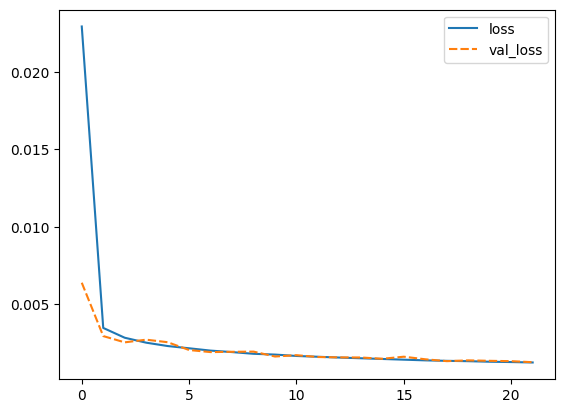

In [25]:
history_df = pd.DataFrame(history.history)
sns.lineplot(history_df.loc[:, ["loss", "val_loss"]])

In [26]:
Train_Predictions = Convolutional_Autoencoder.predict(X_train[:1000])

32/32 [==============================] - 1s 13ms/step


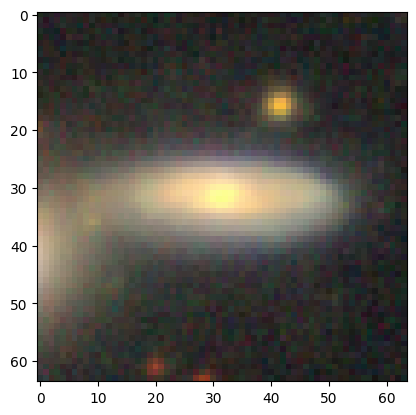

In [27]:
plt.imshow(X_train[600])

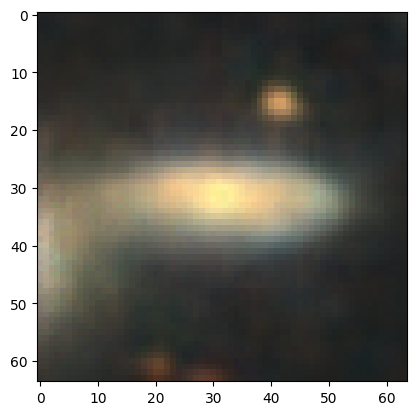

In [28]:
plt.imshow(Train_Predictions[600])

In [29]:
Encoder = Convolutional_Autoencoder.layers[0]
Encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 residual__block (Residual_B  (None, 32, 32, 32)       20228     
 lock)                                                           
                                                                 
 residual__block_1 (Residual  (None, 16, 16, 64)       60432     
 _Block)                                                         
                                                                 
 residual__block_2 (Residual  (None, 8, 8, 128)        239648    
 _Block)                                                         
                                                             

In [30]:
inputs = tf.keras.layers.Input(shape = (64, 64, 3))
outputs = Convolutional_Autoencoder.layers[0](inputs)
outputs = tf.keras.layers.Flatten()(outputs)
Encoder = tf.keras.Model(inputs = inputs, outputs = outputs)
Encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 model (Functional)          (None, 4, 4, 256)         1275636   
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
Total params: 1,275,636
Trainable params: 1,272,756
Non-trainable params: 2,880
_________________________________________________________________


In [31]:
tsne = TSNE(n_components =2)
X_train_compressed = Encoder.predict(X_train)
X_train_2D = tsne.fit_transform(X_train_compressed)
plt.scatter(X_train_2D[:, 0], X_train_2D[:, 1], c = y_train, s = 10, cmap = "tab10")

444/444 [==============================] - 2s 4ms/step


In [32]:
tsne = TSNE(n_components =2)
X_test_compressed = Encoder.predict(X_test)
X_test_2D = tsne.fit_transform(X_test_compressed)
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c = y_test, s = 10, cmap = "tab10")

111/111 [==============================] - 1s 6ms/step


In [33]:
tsne = TSNE(n_components =3)
X_test_compressed = Encoder.predict(X_test)
X_test_3D = tsne.fit_transform(X_test_compressed)

111/111 [==============================] - 0s 4ms/step


In [ ]:
np.save("Visual_Data.npy", X_test_3D)

In [ ]:
np.save("Test_y.npy", y_test)

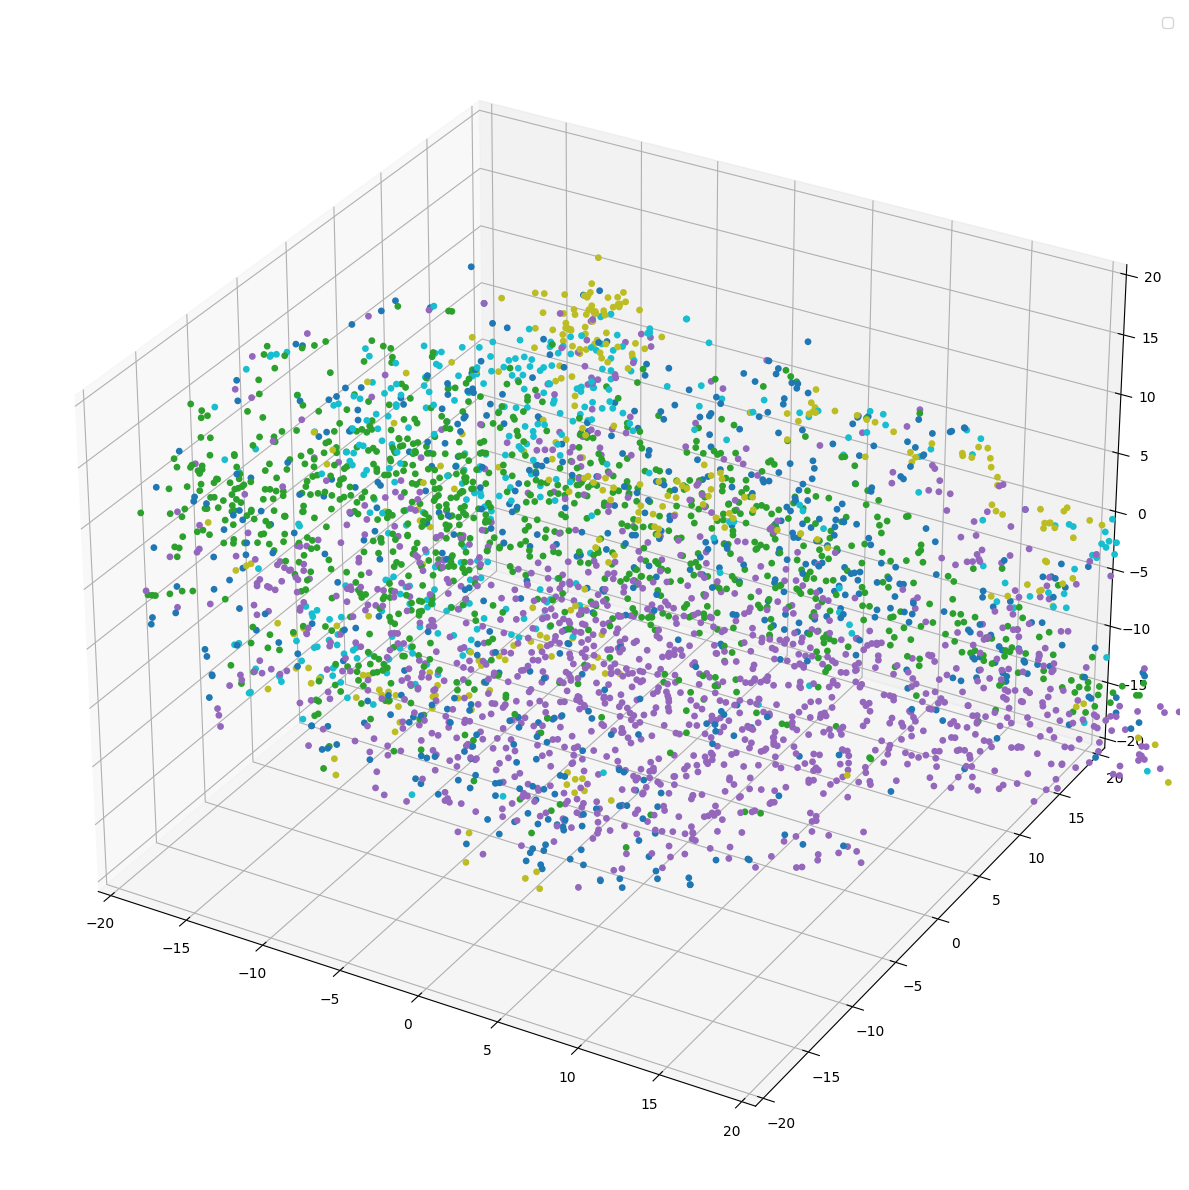

In [34]:
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection = "3d")
fig = ax.scatter3D(X_test_3D[:,0], X_test_3D[:,1], X_test_3D[:,2], s= 15, alpha = 1, c = y_test, cmap = "tab10")
ax.legend()
ax.set_zlim([-20,20])
ax.set_xlim([-20,20])
ax.set_ylim([-20,20])
plt.tight_layout()
plt.show()

In [35]:
import plotly.graph_objects as go
fig = go.Figure(data = [go.Scatter3d(x = X_test_3D[:,0], 
                                     y = X_test_3D[:,1], 
                                     z = X_test_3D[:,2], 
                                     mode = "markers", 
                                     marker = dict(size = 5, color = y_test, colorscale = "Viridis", showscale = True),
                                     )
                                     ])
fig.show()

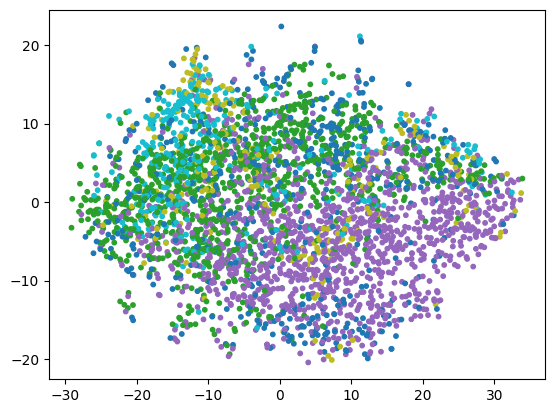

In [37]:
plt.scatter(X_test_3D[:, 0], X_test_3D[:, 1], c = y_test, s = 10, cmap = "tab10")

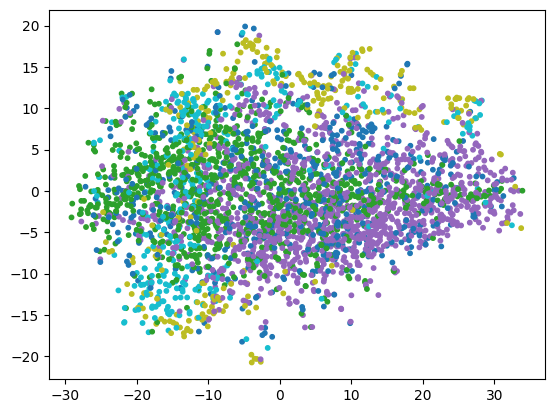

In [38]:
plt.scatter(X_test_3D[:, 0], X_test_3D[:, 2], c = y_test, s = 10, cmap = "tab10")

In [46]:
inputs = tf.keras.layers.Input(shape = (64, 64, 3))
outputs = Convolutional_Autoencoder.layers[0](inputs)
outputs = tf.keras.layers.Flatten()(outputs)

outputs = tf.keras.layers.Dense(500,activation = "gelu", kernel_initializer = "he_normal", kernel_regularizer = "l1_l2")(outputs)
outputs = tf.keras.layers.Dropout(0.5)(outputs)
outputs = tf.keras.layers.BatchNormalization()(outputs)

outputs = tf.keras.layers.Dense(250,activation = "gelu", kernel_initializer = "he_normal", kernel_regularizer = "l1_l2")(outputs)
outputs = tf.keras.layers.Dropout(0.5)(outputs)
outputs = tf.keras.layers.BatchNormalization()(outputs)

outputs = tf.keras.layers.Dense(100,activation = "gelu", kernel_initializer = "he_normal", kernel_regularizer = "l1_l2")(outputs)
outputs = tf.keras.layers.Dropout(0.5)(outputs)
outputs = tf.keras.layers.BatchNormalization()(outputs)

outputs = tf.keras.layers.Dense(5, activation = "softmax")(outputs)

Galaxy_Classifier = tf.keras.Model(inputs = inputs, outputs = outputs)
Galaxy_Classifier.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 model (Functional)          (None, 4, 4, 256)         1275636   
                                                                 
 flatten_2 (Flatten)         (None, 4096)              0         
                                                                 
 dense_12 (Dense)            (None, 500)               2048500   
                                                                 
 dropout_3 (Dropout)         (None, 500)               0         
                                                                 
 batch_normalization_15 (Bat  (None, 500)              2000      
 chNormalization)                                                
                                                           

In [47]:
Galaxy_Classifier.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Nadam(learning_rate = 1e-3),
    metrics = [tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC(), tf.keras.metrics.Precision()],
)

1. 

In [48]:
np.array(y_train)

array([2, 1, 0, ..., 1, 0, 4])

In [49]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
Train_y = ohe.fit_transform(np.array(y_train).reshape(-1,1)).toarray()
Test_y = ohe.transform(np.array(y_test).reshape(-1,1)).toarray()

In [50]:
Train_y = tf.constant(Train_y)
Test_y = tf.constant(Test_y)

In [51]:
history = Galaxy_Classifier.fit(
    X_train, Train_y,
    validation_data = (X_test, Test_y),
    epochs = 200,
    batch_size = 64, 
    callbacks = [early_stopping, reduce_learn_on_plateau],
    use_multiprocessing = True
)

Epoch 1/200
222/222 [==============================] - 31s 50ms/step - loss: 65.3260 - categorical_accuracy: 0.5437 - auc_1: 0.8165 - precision_1: 0.6347 - val_loss: 6.5919 - val_categorical_accuracy: 0.3712 - val_auc_1: 0.7021 - val_precision_1: 0.0000e+00 - lr: 0.0010
Epoch 2/200
222/222 [==============================] - 9s 42ms/step - loss: 4.3601 - categorical_accuracy: 0.6905 - auc_1: 0.9115 - precision_1: 0.7644 - val_loss: 4.4544 - val_categorical_accuracy: 0.3720 - val_auc_1: 0.7334 - val_precision_1: 0.0000e+00 - lr: 0.0010
Epoch 3/200
222/222 [==============================] - 9s 42ms/step - loss: 3.4835 - categorical_accuracy: 0.7197 - auc_1: 0.9285 - precision_1: 0.7884 - val_loss: 3.5235 - val_categorical_accuracy: 0.7001 - val_auc_1: 0.9252 - val_precision_1: 0.8443 - lr: 0.0010
Epoch 4/200
222/222 [==============================] - 9s 42ms/step - loss: 3.2960 - categorical_accuracy: 0.7429 - auc_1: 0.9383 - precision_1: 0.8057 - val_loss: 3.3231 - val_categorical_accura

In [62]:
history_df = pd.DataFrame(history.history)
sns.lineplot(history_df.loc[:, ["loss", "val_loss"]])

<Axes: >

In [53]:
Galaxy_Classifier.evaluate(X_test, Test_y)

111/111 [==============================] - 1s 8ms/step - loss: 0.9296 - categorical_accuracy: 0.8619 - auc_1: 0.9524 - precision_1: 0.8634


[0.9295938014984131,
 0.8618940114974976,
 0.9523501396179199,
 0.8634049892425537]

In [54]:
Galaxy_Classifier.evaluate(X_train, Train_y)

444/444 [==============================] - 3s 7ms/step - loss: 0.1084 - categorical_accuracy: 0.9970 - auc_1: 1.0000 - precision_1: 0.9970


[0.10841778665781021,
 0.9969692826271057,
 0.9999953508377075,
 0.9970393180847168]

In [55]:
Predictions = np.argmax(Galaxy_Classifier.predict(X_test), axis = 1)

111/111 [==============================] - 1s 5ms/step


In [56]:
predictions = Galaxy_Classifier.predict(X_test)

111/111 [==============================] - 1s 5ms/step


In [57]:
Predictions

array([2, 1, 2, ..., 2, 0, 2])

In [58]:
np.argmax(Train_y, axis = 1)

array([2, 1, 0, ..., 1, 0, 3])

In [59]:
#Compute the confusion matrix for the random forest model's 
#predictions
from sklearn.metrics import confusion_matrix
from sklearn import metrics
confusion_mat = confusion_matrix(Predictions, np.argmax(Test_y, axis = 1))
confusion_visualized = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_mat)
confusion_visualized.plot()

In [60]:
#Evaulates the performance of the model's predictions across the different models.
from sklearn.metrics import classification_report
target_names = ["DisturbedGalaxies", "Ellipticals", "Spiral_Galaxies", "Edge_On_NoBulge_Galaxies", "Edge_On_Bulge_Galaxies"]
print(classification_report(np.argmax(Test_y,axis = 1), Predictions, target_names=target_names))

                          precision    recall  f1-score   support

       DisturbedGalaxies       0.77      0.64      0.70       577
             Ellipticals       0.88      0.92      0.90      1008
         Spiral_Galaxies       0.88      0.89      0.89      1317
Edge_On_NoBulge_Galaxies       0.83      0.93      0.88       283
  Edge_On_Bulge_Galaxies       0.90      0.89      0.90       363

                accuracy                           0.86      3548
               macro avg       0.85      0.85      0.85      3548
            weighted avg       0.86      0.86      0.86      3548



In [61]:
#Produces the ROC curve for the support vector machines predictions
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
fig, ax = plt.subplots(figsize = (6,6))
colors = cycle(["aqua", "darkorange", "cornflowerblue", "purple", "darkred"])
for class_id, colors in zip(range(5), colors):
    RocCurveDisplay.from_predictions(
        Test_y[:,class_id],
        predictions[:, class_id],
        name = f"ROC curve for {target_names[class_id]}",
        color = colors,
        ax = ax,
    )
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n Bhadron Masses vs the Rest:")
plt.legend()
plt.show()